In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import skrf as rf

#define the targeted max frequency
fmax = 200
#define function for loading images and s-parameters
#"path" is the path for images of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each images 
def load_images_from_path(path, label, length):

    images = []
    labels = []
    error = []
    
    for kk in range(length):
        try:
            # Load S-parameters
            results = []
            datafile = f"{label}{kk}.s4p"
            if not os.path.exists(datafile):
                #print(f"S-parameter file not found: {datafile}. Skipping...")
                error.append(kk)
                datafile = f"{label}{0}.s4p"
            # Load images
            img_path = f"{path}{kk}.png"
            if not os.path.exists(img_path):
                #print(f"Image file not found: {img_path}. Skipping...")
                error.append(kk)
                img_path = f"{path}{0}.png"
    
            img = image.load_img(img_path, target_size=(300, 300, 3))
            images.append(image.img_to_array(img)[38:262, 38:262, :])  # Trim the ground margin
            spt = rf.Network(datafile)
            if len(spt.f)==601:
                error.append(kk)
                datafile = f"{label}{1000}.s4p"
                spt = rf.Network(datafile)
            step = int(1e9 / (spt.f[1] - spt.f[0]))
            for k in range(fmax + 1):
                i = int(k * step/2)
                results.append([
                    spt.s[i][0][0].real, spt.s[i][0][0].imag,
                    spt.s[i][0][1].real, spt.s[i][0][1].imag,
                    spt.s[i][0][2].real, spt.s[i][0][2].imag,
                    spt.s[i][0][3].real, spt.s[i][0][3].imag,
                    spt.s[i][2][2].real, spt.s[i][2][2].imag,
                    spt.s[i][2][3].real, spt.s[i][2][3].imag
                ])
            
            labels.append(results)
            '''
            # Validation checks
            sp = np.array(results)
            invalid = False
            for ff in range(len(sp) - 8):
                k = ff + 5
                for x in range(6):
                    if (np.square(sp[k][x]) + np.square(sp[k][x + 1])) > 1.02:
                        invalid = True
                for x in range(12):
                    if abs(sp[k][x] + sp[k + 2][x] - 2 * sp[k + 1][x]) > 0.15:
                        invalid = True
            if invalid:
                print(f"Invalid data detected at index {kk}.")
                error.append(kk)
        '''
        except Exception as e:
            print(f"An error occurred at index {kk}: {e}")
            error.append(kk)
    
    return images, labels, error

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

2025-09-18 15:39:54.955250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]
(5000, 15)
(5000,)


'\n\nlogfile = open("/rdf/shared/design_automation/Data/XFMR8ShapedBasic/log.txt","r")\nlistall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(\',\'))), logfile.read().strip().split(\'\n\')))\ntabular_data = np.array(listall)\n\n#load images and s-parameters\nlength = len(tabular_data)\nimages, labels,error = load_images_from_path(\'/rdf/shared/design_automation/Data/XFMR8ShapedBasic/PNG/\', \'/rdf/shared/design_automation/Data/XFMR8ShapedBasic/SPData/\',length)\nprint(error)\nshow_images(images)\nsrf = np.load(\'/rdf/shared/design_automation/Data/XFMR8ShapedBasic/srf.npy\')\nprint(len(srf))\n\nfor kk in range(length):\n    #select 1 turn and 1 turn transformers\n    if kk in error:\n        continue  \n    if((tabular_data[kk,2]!=0) and (tabular_data[kk,3]!=0)):\n       #geoparas only includes the variable parameters in our designs. \n       #Constants at this design stages are excluded \n        geoparas.append(tabular_data[kk,(0,1,4,5,6,7,8,9,10,1

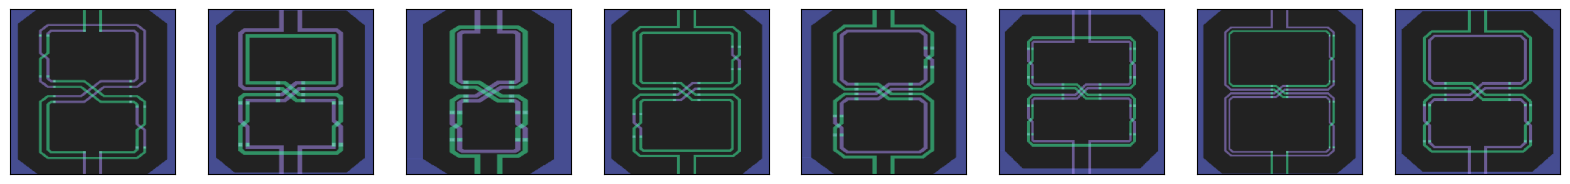

In [2]:
#load data
#geometrical parameters stored in log.txt
#order of geopara (radiusA,radiusB,turnsA,turnsB,openA,openB,outA,outB,extA,extB,ratio,outbound)
geoparas = []
images11 = []
labels11 = []
srf_list = []


logfile = open("/rdf/shared/design_automation/Data_EMX/XFMR8Shaped1x2_2504/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

#load images and s-parameters
length = len(tabular_data)
images, labels,error = load_images_from_path('/rdf/shared/design_automation/Data_EMX/XFMR8Shaped1x2_2504/PNG/', '/rdf/shared/design_automation/Data_EMX/XFMR8Shaped1x2_2504/SPData/',length)
print(error)
show_images(images)
srf = np.load('/rdf/shared/design_automation/Data_EMX/XFMR8Shaped1x2_2504/srf.npy')

for kk in range(length):
    #select 1 turn and 1 turn transformers
    if kk in error:
        continue   
    if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
        temp = next((item for item in reversed(tabular_data) if item[19] == kk), None)
        geoparas.append(np.array(temp)[[0,1,4,5,6,7,8,9,10,11,14,15,16,17,18]])
        images11.append(images[kk])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(geoparas))

print(np.shape(srf_list))
'''

logfile = open("/rdf/shared/design_automation/Data/XFMR8ShapedBasic/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

#load images and s-parameters
length = len(tabular_data)
images, labels,error = load_images_from_path('/rdf/shared/design_automation/Data/XFMR8ShapedBasic/PNG/', '/rdf/shared/design_automation/Data/XFMR8ShapedBasic/SPData/',length)
print(error)
show_images(images)
srf = np.load('/rdf/shared/design_automation/Data/XFMR8ShapedBasic/srf.npy')
print(len(srf))

for kk in range(length):
    #select 1 turn and 1 turn transformers
    if kk in error:
        continue  
    if((tabular_data[kk,2]!=0) and (tabular_data[kk,3]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
        geoparas.append(tabular_data[kk,(0,1,4,5,6,7,8,9,10,11,14,15,16,17,18)])
        images11.append(images[kk])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(geoparas))


logfile = open("/rdf/shared/design_automation/Data/XFMR8Shaped_2503/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

#load images and s-parameters
#length = len(listall)-3
length = 850
images, labels,error = load_images_from_path('/rdf/shared/design_automation/Data/XFMR8Shaped_2503/PNG/', '/rdf/shared/design_automation/Data/XFMR8Shaped_2503/SPData/',length)
print(error)
srf = np.load('/rdf/shared/design_automation/Data/XFMR8Shaped_2503/srf.npy')

for kk in range(length):
    #select 1 turn and 1 turn transformers
    if kk in error:
        continue   
    if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
        temp = next((item for item in reversed(tabular_data) if item[19] == kk), None)
        geoparas.append(np.array(temp)[[0,1,4,5,6,7,8,9,10,11,14,15,16,17,18]])
        images11.append(images[kk])
        labels11.append(labels[kk])
        srf_list.append(srf[kk])
print(np.shape(geoparas))
'''

In [3]:
print(np.shape(srf_list))

(5000,)


In [4]:
#normalize geometrical inputs
geoparas_temp = np.array(geoparas)
geoparas = np.zeros(np.shape(geoparas_temp))
for i in range(len(geoparas)):
    for j in range(14):
        geoparas[i,j]= (geoparas_temp[i,j]-np.mean(geoparas_temp[:,j]))/np.std(geoparas_temp[:,j])

In [5]:
#construct the datasets
class item:
  def __init__(self, image,geopara,label,srf):
    self.image = image
    self.geopara = geopara
    self.label = label
    self.srf = srf
data = []
for i in range(len(images11)):
    data.append(item(images11[i],geoparas[i],labels11[i],srf_list[i]))

np.random.shuffle(data)

In [6]:
#define the split length for training, validation and test datasets
length = len(images11)
split1 = int(0.2*length)
split2 = int(0.8*length)
data_train = data[0:split1]
data_valid = data[split1:split2]
data_test = data[split2:]

In [7]:
#Separate the training, validation and test datasets 
train_images = []
train_labels = []
train_geoparas = []
train_srf = []
valid_images = []
valid_labels = []
valid_geoparas = []
valid_srf = []
test_images = []
test_labels = []
test_geoparas = []
test_srf = []

#The targeted frequency span up to fmax, with 1GHz step
s_max = np.zeros((fmax,12))
s_min = np.zeros((fmax,12))
srange = np.zeros((fmax,12))


for i in range(len(data_train)):
    train_images.append(data_train[i].image)
    train_geoparas.append(data_train[i].geopara)
    train_labels.append(data_train[i].label)
    train_srf.append(data_train[i].srf)
x_train_img = np.array(train_images) / 255
x_train_srf = np.array(train_srf)
x_train_geopara = np.array(train_geoparas)
y_train_encoded = np.array(train_labels)[:,1:fmax+1,:]


for i in range(len(data_valid)):
    valid_images.append(data_valid[i].image)
    valid_geoparas.append(data_valid[i].geopara)
    valid_labels.append(data_valid[i].label)
    valid_srf.append(data_valid[i].srf)
x_valid_img = np.array(valid_images) / 255
x_valid_srf = np.array(valid_srf)
x_valid_geopara = np.array(valid_geoparas)
y_valid_encoded = np.array(valid_labels)[:,1:fmax+1,:]


for i in range(len(data_test)):
    test_images.append(data_test[i].image)
    test_geoparas.append(data_test[i].geopara)
    test_labels.append(data_test[i].label)
    test_srf.append(data_test[i].srf)
x_test_img = np.array(test_images) / 255
x_test_srf = np.array(test_srf)
x_test_geopara = np.array(test_geoparas)
y_test_encoded = np.array(test_labels)[:,1:fmax+1,:]

#normalize the s-parameters for each frequency point
for z in range(fmax):
    for i in range(12):
        s_max[z,i] = max(max(y_train_encoded[:,z,i]),max(y_valid_encoded[:,z,i]),max(y_test_encoded[:,z,i]))
        s_min[z,i] = min(min(y_train_encoded[:,z,i]),min(y_valid_encoded[:,z,i]),min(y_test_encoded[:,z,i]))
        srange[z,i] = s_max[z,i]-s_min[z,i]
    
    for i in range(12):
        y_train_encoded[:,z,i] = 2*(y_train_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

    for i in range(12):
        y_valid_encoded[:,z,i] = 2*(y_valid_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1
    
    for i in range(12):
        y_test_encoded[:,z,i] = 2*(y_test_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -----------------------------
# Config
# -----------------------------
n_channel = 16
emb_dim = 512         # matches your Linear(..., 512) in cnn
ar_token_dim = 256    # token dimension for AR pretraining
ar_hidden = 512       # GRU hidden size

# -----------------------------
# Losses / Metrics
# -----------------------------
def custom_loss(y_true, y_pred):
    Lf = torch.sqrt(torch.mean((y_true - y_pred) ** 2, dim=1))
    return torch.mean(Lf)

def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

# -----------------------------
# Models
# -----------------------------
class ImageEncoder(nn.Module):
    """
    Convolutional encoder identical to your cnn backbone+proj
    so we can load weights directly into PyTorchModel.cnn.
    """
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, n_channel, kernel_size=3, stride=1, padding=1),  # 224
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                           # 112
            nn.Conv2d(n_channel, n_channel*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                           # 56
            nn.Conv2d(n_channel*2, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                           # 28
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                           # 14
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                           # 7
        )
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*n_channel*4, emb_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        feat = self.backbone(x)   # (B, C=4*n_channel, 7, 7)
        z = self.proj(feat)       # (B, 512)
        return z, feat

class ARPretrainer(nn.Module):
    """
    Autoregressive pretrainer over 7x7 tokens (raster order).
    Uses teacher forcing and MSE token reconstruction.
    """
    def __init__(self, encoder: ImageEncoder, token_dim=ar_token_dim, hidden=ar_hidden):
        super().__init__()
        self.encoder = encoder
        self.to_token = nn.Conv2d(4*n_channel, token_dim, kernel_size=1)
        self.gru = nn.GRU(input_size=token_dim, hidden_size=hidden, batch_first=True)
        self.pred = nn.Linear(hidden, token_dim)

    @torch.no_grad()
    def encode_tokens(self, x):
        _, feat = self.encoder(x)            # (B, C, 7, 7)
        tok = self.to_token(feat)            # (B, D, 7, 7)
        tok = tok.flatten(2).transpose(1, 2) # (B, 49, D)
        return tok

    def forward(self, x):
        with torch.no_grad():
            tokens = self.encode_tokens(x)   # (B, T=49, D)
        # teacher forcing: predict token_t from previous token
        bos = torch.zeros(tokens.size(0), 1, tokens.size(2), device=tokens.device, dtype=tokens.dtype)
        inputs = torch.cat([bos, tokens[:, :-1, :]], dim=1)  # (B, T, D)
        out, _ = self.gru(inputs)                            # (B, T, H)
        pred_next = self.pred(out)                           # (B, T, D)
        loss = F.mse_loss(pred_next, tokens)
        return loss

class PyTorchModel(nn.Module):
    def __init__(self, fmax):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, n_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(n_channel, n_channel*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(n_channel*2, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(7*7*n_channel*4, emb_dim),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(emb_dim, fmax * 12),
            nn.Tanh(),
        )
        self.reshape = nn.Unflatten(1, (fmax, 12))

    def forward(self, x1):
        x = self.cnn(x1)
        x = self.fc(x)
        x = self.reshape(x)
        return x

# -----------------------------
# Weight transfer utility
# -----------------------------
def load_encoder_into_model(task_model: PyTorchModel, encoder: ImageEncoder):
    # Build a temp sequential mirroring encoder order for state_dict key match
    tmp = nn.Sequential(*[m for m in encoder.backbone], *[m for m in encoder.proj])
    enc_sd = tmp.state_dict()
    cnn_sd = task_model.cnn.state_dict()
    filtered = {k: v for k, v in enc_sd.items() if k in cnn_sd and cnn_sd[k].shape == v.shape}
    cnn_sd.update(filtered)
    task_model.cnn.load_state_dict(cnn_sd)

# ============================================================
# Your original training code + AR pretrain merged together
# ============================================================
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Your original hyperparams / band slicing (expects fmax defined) -----
nband = int(1)
overlap = int(1)
fband = int(fmax * overlap / nband)     # assumes you defined fmax earlier
bandslice = int(fband / overlap)

# ----- Build supervised model (after pretrain we'll load weights here) -----
model = PyTorchModel(fband).to(device)

# ----- Optimizer / scheduler for supervised phase -----
learning_rate = 1e-4
epochs = 300
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

# ----- Prepare your tensors/dataloader (unchanged) -----
batch_size = 32
xx = 0
yout = torch.from_numpy(y_train_encoded[:, (xx * fband):(xx + 1) * fband]).type(torch.float32)
x1 = torch.from_numpy(x_train_img)                             # NHWC
x1 = x1.permute(0, 3, 1, 2).contiguous()                       # NCHW
x2 = torch.from_numpy(x_train_geopara).type(torch.float32)

dataset = torch.utils.data.TensorDataset(x1, x2, yout)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Also create an unlabeled image dataloader for AR pretraining (uses the same x1 here)
# If you have extra unlabeled images, substitute them here instead.
unlabeled_img_dataset = torch.utils.data.TensorDataset(x1)     # just images
unlabeled_img_loader = torch.utils.data.DataLoader(unlabeled_img_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# -----------------------------
# Phase 1: AR pretraining
# -----------------------------
def pretrain_encoder_ar(unlabeled_loader, device='cuda', epochs=10, lr=1e-3, freeze_bn=True):
    encoder = ImageEncoder().to(device)
    ar = ARPretrainer(encoder).to(device)

    # Optionally freeze BatchNorm if you later care about exact running stats mapping.
    if freeze_bn:
        for m in encoder.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                for p in m.parameters():
                    p.requires_grad = False

    opt = optim.AdamW(ar.parameters(), lr=lr)
    ar.train()
    for ep in range(epochs):
        total = 0.0
        n = 0
        for (imgs,) in unlabeled_loader:
            imgs = imgs.to(device, non_blocking=True).float()
            loss = ar(imgs)
            opt.zero_grad()
            loss.backward()
            opt.step()
            bs = imgs.size(0)
            total += loss.item() * bs
            n += bs
        print(f"[AR] epoch {ep+1}/{epochs} loss={total/max(1,n):.6f}")
    return ar.encoder

# -----------------------------
# Phase 2: Supervised training
# -----------------------------
def train_model(model, optimizer, scheduler, loss_function, num_epochs, dataloader, device='cuda'):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        n = 0

        for batch in dataloader:
            inp1, inp2, y_true = batch
            inp1 = inp1.to(device, non_blocking=True).float()
            # inp2 is currently unused by the model, but we keep it to preserve your dataset API
            y_true = y_true.to(device, non_blocking=True).float()

            optimizer.zero_grad()
            y_pred = model(inp1)

            loss = loss_function(y_true.view(y_true.size(0), -1),
                                 y_pred.view(y_pred.size(0), -1))
            loss.backward()
            optimizer.step()

            batch_mae = mae(y_true, y_pred)
            bs = inp1.size(0)
            running_loss += loss.item() * bs
            running_mae += batch_mae.item() * bs
            n += bs

        scheduler.step()
        if (epoch % 20) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/max(1,n):.6f}, MAE: {running_mae/max(1,n):.6f}")

# -----------------------------
# Execute both phases
# -----------------------------
# 1) Pretrain encoder on images
encoder = pretrain_encoder_ar(unlabeled_img_loader, device=device, epochs=10, lr=1e-3)

# 2) Load encoder weights into task model
load_encoder_into_model(model, encoder)
print("Loaded pretrained encoder weights into task model.")

# (Optional) Warm-start: freeze cnn for a few epochs then unfreeze
# for p in model.cnn.parameters(): p.requires_grad = False
# ... run a few epochs, then unfreeze:
# for p in model.cnn.parameters(): p.requires_grad = True

# 3) Train your supervised model (your original loop)
train_model(model, optimizer, scheduler, custom_loss, epochs, dataloader, device=device)

Using device: cuda
[AR] epoch 1/10 loss=0.000579
[AR] epoch 2/10 loss=0.000044
[AR] epoch 3/10 loss=0.000022
[AR] epoch 4/10 loss=0.000011
[AR] epoch 5/10 loss=0.000005
[AR] epoch 6/10 loss=0.000003
[AR] epoch 7/10 loss=0.000002
[AR] epoch 8/10 loss=0.000001
[AR] epoch 9/10 loss=0.000001
[AR] epoch 10/10 loss=0.000001
Loaded pretrained encoder weights into task model.
Epoch [1/300], Loss: 0.432793, MAE: 0.369510
Epoch [21/300], Loss: 0.159814, MAE: 0.123183
Epoch [41/300], Loss: 0.122601, MAE: 0.093571
Epoch [61/300], Loss: 0.105374, MAE: 0.079990
Epoch [81/300], Loss: 0.094694, MAE: 0.071863
Epoch [101/300], Loss: 0.086082, MAE: 0.065387
Epoch [121/300], Loss: 0.077495, MAE: 0.058952
Epoch [141/300], Loss: 0.071497, MAE: 0.054347
Epoch [161/300], Loss: 0.067058, MAE: 0.050835
Epoch [181/300], Loss: 0.064403, MAE: 0.049008
Epoch [201/300], Loss: 0.060977, MAE: 0.046430
Epoch [221/300], Loss: 0.057712, MAE: 0.043863
Epoch [241/300], Loss: 0.056145, MAE: 0.042850
Epoch [261/300], Loss: 0

In [9]:
torch.save(model.state_dict(), './models/cnn_1band/'+str(xx) + '.pth')

In [10]:
# Frequency forward loop
def forward_loop():
    for ff in range(nband - overlap):
        xx = ff + 1
    #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./models/cnn_1band/'+str(xx - 1) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './models/cnn_1band/'+str(xx) + '.pth')


In [11]:
# Frequency backward loop
def backward_loop():
    for ff in range(nband - overlap):
        xx = nband - ff - 1 - overlap
        #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./models/cnn_1band/'+str(xx + 1) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './models/cnn_1band/'+str(xx) + '.pth')


In [12]:
def prediction_srf(ax):
    test_prediction_raw = np.zeros((len(x_test_img),fmax*overlap,12))
    test_prediction = np.zeros((len(x_test_img),fmax,12))
    xtest = torch.from_numpy(x_test_img)
    xtest = xtest.type(torch.float32)
    xtest = xtest.permute(0, 3, 1, 2)
    for xx in range(nband+1-overlap):
        model_cpu = PyTorchModel(fmax=fband)
        model_cpu.load_state_dict(torch.load('./models/cnn_1band/'+str(xx)+'.pth'))
        test_prediction_raw[:,fband*xx:fband*(xx+1),:] = model_cpu(xtest).detach().numpy()
        mae_all = np.zeros((fmax,12))
    mae_mean = np.zeros(fmax)
    for xx in range(nband):
        print(xx)
        if xx<overlap:
            for yy in range(1+xx):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(1+xx)
        elif(nband-xx<overlap):
            for yy in range(2+xx-nband):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx+1-overlap-yy)+(overlap-1-yy)*bandslice:fband*(xx+1-overlap-yy)+(overlap-yy)*bandslice,:])
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(2+xx-nband)
        else:
            for yy in range(overlap):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(overlap)
    n_srf = 100
    srf_mae_all = np.zeros((n_srf,12))
    srf_mae = np.zeros(n_srf)
    for z in range(n_srf):
        for sample in range(len(xtest)):
            freq_temp = int(min(fmax-1,z*test_srf[sample]*4/n_srf))            
            for i in range(12):
                srf_mae_all[z][i] += (abs(test_prediction[sample,freq_temp,i]-y_test_encoded[sample,freq_temp,i]))*0.5*srange[freq_temp,i]
        srf_mae_all[z] = srf_mae_all[z]/len(xtest)
        srf_mae[z] = np.mean(srf_mae_all[z][:])
    ax.plot((2/n_srf)*np.ones(n_srf)*range(n_srf),srf_mae)
    #ax.plt.xlabel('Frequency Normalized to SRF')
    #plt.ylabel('Average S-parameter mae')
    print(np.mean(srf_mae))
    print(R_squared(torch.from_numpy(y_test_encoded),torch.from_numpy(test_prediction)))
    return np.mean(srf_mae)
    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

In [13]:
def prediction(ax):
    test_prediction_raw = np.zeros((len(x_test_img),fmax*overlap,12))
    test_prediction = np.zeros((len(x_test_img),fmax,12))
    xtest = torch.from_numpy(x_test_img)
    xtest = xtest.type(torch.float32)
    xtest = xtest.permute(0, 3, 1, 2)
    for xx in range(nband+1-overlap):
        model_cpu = PyTorchModel(fmax=fband)
        model_cpu.load_state_dict(torch.load('./models/cnn_1band/'+str(xx)+'.pth'))
        test_prediction_raw[:,fband*xx:fband*(xx+1),:] = model_cpu(xtest).detach().numpy()
        mae_all = np.zeros((fmax,12))
    mae_mean = np.zeros(fmax)
    for xx in range(nband):
        print(xx)
        if xx<overlap:
            for yy in range(1+xx):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(1+xx)
        elif(nband-xx<overlap):
            for yy in range(2+xx-nband):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx+1-overlap-yy)+(overlap-1-yy)*bandslice:fband*(xx+1-overlap-yy)+(overlap-yy)*bandslice,:])
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(2+xx-nband)
        else:
            for yy in range(overlap):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(overlap)
    for z in range(fmax):
        for i in range(12):
            mae_all[z][i] = np.mean(abs(test_prediction[:,z,i]-y_test_encoded[:,z,i]))*0.5*srange[z,i]
        mae_mean[z] = np.mean(mae_all[z][:])
    ax.plot(range(fmax),mae_mean)
    #ax.plt.xlabel('Frequency/GHz')
    #ax.plt.ylabel('Average S-parameter mae')
    print(np.mean(mae_mean))
    print(R_squared(torch.from_numpy(y_test_encoded),torch.from_numpy(test_prediction)))
    return np.mean(mae_mean)
    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

0


/tmp/ipykernel_1343786/3377445858.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cpu.load_state_dict(torch.load('./models/cnn_1band/'+str(xx)+'.pth'))


0
0.020945926247420855
tensor(0.9728, dtype=torch.float64)
0
0.012480804980107256
tensor(0.9728, dtype=torch.float64)
1
0
0.020945926247420855
tensor(0.9728, dtype=torch.float64)
0
0.012480804980107256
tensor(0.9728, dtype=torch.float64)
2
0
0.020945926247420855
tensor(0.9728, dtype=torch.float64)
0
0.012480804980107256
tensor(0.9728, dtype=torch.float64)
3
0
0.020945926247420855
tensor(0.9728, dtype=torch.float64)
0
0.012480804980107256
tensor(0.9728, dtype=torch.float64)
4
0
0.020945926247420855
tensor(0.9728, dtype=torch.float64)
0
0.012480804980107256
tensor(0.9728, dtype=torch.float64)


Text(0, 0.5, 'Average S-parameter mae')

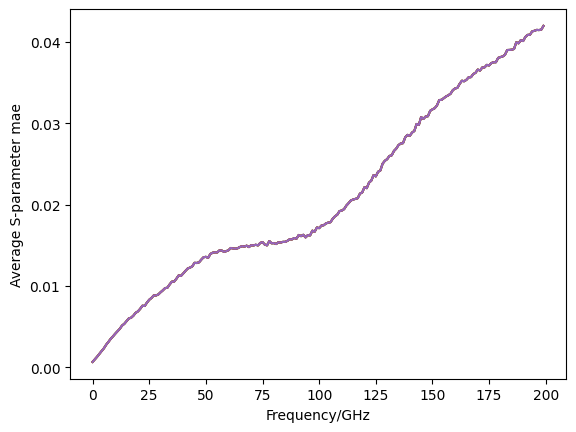

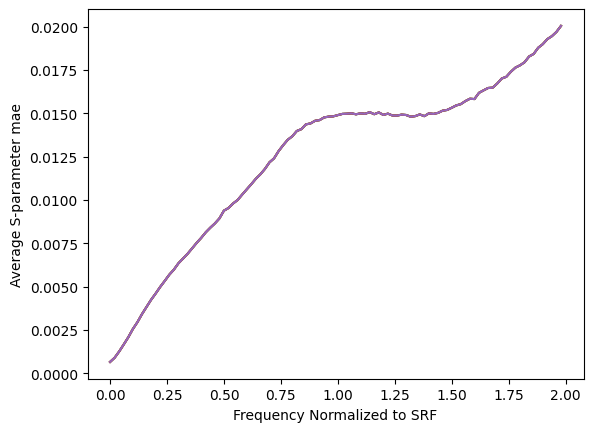

In [14]:
epochs = 200
iteration = 5
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
mae_trend = np.zeros(iteration)
for ii in range(iteration):
    epochs = epochs
    forward_loop()
    backward_loop()
    print(ii)
    mae_trend[ii]=prediction(ax1)
    prediction_srf(ax2)
ax1.set_xlabel('Frequency/GHz')
ax1.set_ylabel('Average S-parameter mae')
ax2.set_xlabel('Frequency Normalized to SRF')
ax2.set_ylabel('Average S-parameter mae')

In [15]:
from torchinfo import summary
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
PyTorchModel                             [1, 200, 12]              --
├─Sequential: 1-1                        [1, 512]                  --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         448
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 16, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-5                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,496
│    └─ReLU: 2-8                         [1, 64, 56, 56]           --
│    └─MaxPool2d: 2-9                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-10                      [1, 64, 28, 28]           36,928
│    └─ReLU: 2-11                        [1, 64, 28, 28]           --
│  

Text(0.5, 0, 'Iteration Times')

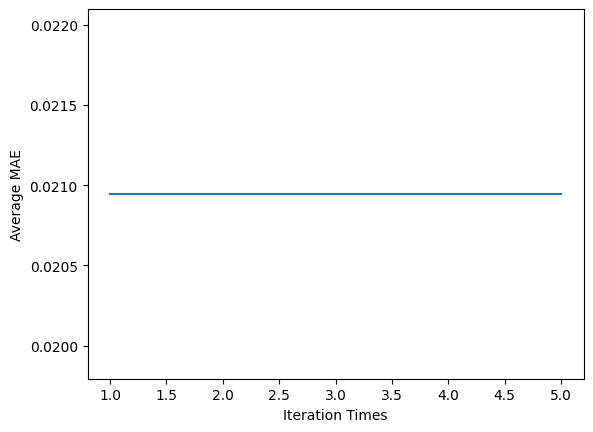

In [16]:
plt.plot(range(iteration)+np.ones(iteration),mae_trend)
plt.ylabel("Average MAE")
plt.xlabel("Iteration Times")